# Evaluating Gene Correlations - Allantois

In [1]:
import numpy as np
import anndata
import pandas as pd
import scanpy as sc
import scipy
import seaborn as sns
import matplotlib.pyplot as plt


from moscot.problems.time._lineage import TemporalProblem

/home/mgander/miniconda3/envs/mc/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/mgander/miniconda3/envs/mc/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
Path="/home/mgander/moscot-framework_reproducibility/data/mouse_temporal"
ts=['E3.5', 'E4.5', 'E5.25', 'E5.5', 'E6.25', 'E6.5', 'E6.75', 'E7.0', 'E7.25', 'E7.5', 'E7.75', 'E8.0', 'E8.25', 'E8.5a', 'E8.5b', 'E9.5', 'E10.5', 'E11.5', 'E12.5', 'E13.5']

In [3]:
ct='E8:Allantois'
i=10

ts0=ts[i]
ts1=ts[i+1]

In [4]:
gT=np.load(f"{Path}/TOME_maps_growth_rate_and_driver_genes_analysis/{ts0}_{ct}_pull.npy", allow_pickle=True)
gM=np.load(f"{Path}/moscot_maps_growth_rate_and_driver_genes_analysis/{ts0}_{ct}_pull.npy", allow_pickle=True)

# Correlation for curated genes

The following list of genes was obtained by litarture seach when looking for genes that predict deveopment into allantois cells. The key in the dictionary corresponds to the citation (Pubmed ID), and the values correspond to the genes the publication lists.

Be careful, I also listed driver/marker genes if there was only moderate evidence of them being directly involved in these cell transitions, so use this list with caution!!!

In [ ]:
D={}
D['PMID: 21932311']=['Tbx4']
D['PMID: 28057264']=['Tbx5']
D['PMID: 22219351']=['Hoxa10', 'Hoxa11', 'Hoxa13']
D['PMID: 16396910']=['Cdx4', 'Cdx1', 'Cdx2']
D['PMID: 22960234']=['Cdx2']
D['PMID: 22855605']=['Kdr']
# Dkk1 blocks Rspo3, hence likely/potentially downregulated
D['PMID: 18842812']=['Rspo3', 'Dkk1']

# These genes are associated with absent allanotis phenotype. Probably not super accurate
D['https://maayanlab.cloud/Harmonizome/gene_set/absent+allantois/MPO+Gene-Phenotype+Associations']=['Ctdnep1', 'Dab2', 'Lin9', 'Mllt4', 'Nodal',
                   'Prkci', 'Slc31a1', 'Smad2', 'T', 'Tfap2c']

genes=[]
for a in D.values():
    genes=[*genes, *a]

# Eliminate duplicates
genes=[a for a in set(genes)]

In [6]:
adata=sc.read(f"{Path}/anndatas/scVI_anndatas/scvi_adata_{ts0}.h5ad")
adata.var.index=list(adata.var['gene_names'])

In [7]:
if 14>i>4:
    ExE_cell_types=['Embryonic visceral endoderm', 'Extraembryonic visceral endoderm', 'Parietal endoderm', 'Extraembryonic ectoderm', 'Primitive erythroid cells', 'Blood progenitors']
    adata=adata[~adata.obs['cell_type'].isin(ExE_cell_types)].copy()
elif i>4:
    ExE_cell_types=['Extraembryonic visceral endoderm']
    adata=adata[~adata.obs['cell_type'].isin(ExE_cell_types)].copy()

In [8]:
hvgs=list(adata.var[adata.var['highly_variable']]['gene_names'])
genes_selected=[]
for gene in genes:
    if gene in hvgs:
        genes_selected.append(gene)
len(genes_selected)

15

In [9]:
[print(a) for a in sorted(genes_selected)]

Cdx1
Cdx2
Cdx4
Dab2
Dkk1
Hoxa10
Hoxa11
Kdr
Nodal
Rspo3
Slc31a1
T
Tbx4
Tbx5
Tfap2c


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [32]:
subset=True

DF=pd.DataFrame({})

for gene in genes_selected:
    loc=adata.var.index.get_loc(gene)
    exp=adata.layers['scvi_normalized'][:,loc]
    #exp=adataS.X[:,loc]
    #exp=np.array(exp.todense()).T[0]

    if subset==True:
        wh=np.where(adata.obs['cell_state'].isin(['E7.75:Allantois', 'E7.75:Extraembryonic mesoderm']))[0]
        
        exp=exp[wh]
        gT2=gT[wh]
        gM2=gM[wh]
    else:
        gT2=gT.copy()
        gM2=gM.copy()
    #sns.scatterplot(x=exp, y=gM2)
    #plt.pause(0.001)


    (cor, p)=scipy.stats.spearmanr(exp, gT2)
    dfT=pd.DataFrame({'Timepoint': ts0, 'Gene':[gene], 'Method': 'TOME', 'Correlation':cor, 'P-value':p, 'type':'Spearman'})
    (cor, p)=scipy.stats.spearmanr(exp, gM2)
    dfM=pd.DataFrame({'Timepoint': ts0, 'Gene':[gene], 'Method': 'moscot', 'Correlation':cor, 'P-value':p, 'type':'Spearman'})
    DF=pd.concat([DF, dfM,dfT])
DF['Abs. Correlation']=abs(DF['Correlation'])
DF.index=np.arange(len(DF))

<Axes: xlabel='Abs. Correlation', ylabel='Timepoint'>

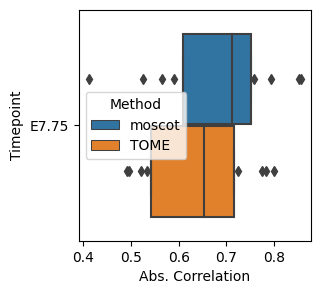

In [33]:
fig, ax = plt.subplots(ncols=1, figsize=(3, 3))
sns.boxplot(data=DF, x="Abs. Correlation", y="Timepoint", hue='Method', showfliers=True,
               showmeans=False,  whis=[100,0], ax=ax)

In [35]:
DF.to_pickle(f'{Path}/Validation_output/{ts0}_Allantois.npy')